# Edit distance nearest neighbors classifier

The goal of this experiment is to evaluate the accuracy of a nearest neighbors classifier for supervised plan classification. Much of the prior work in analyzing student code uses some form of edit distance between programs, usually tree distance on abstract syntax trees. We translate that idea into an NN classifier that classifies programs based on the nearest neighbor by tree edit distance.

In [5]:
from zss import simple_distance, Node
from autoplan.token import OCamlTokenizer
from scripts.rainfall_ingest import ingest_dataset
from tqdm.auto import tqdm
from iterextras import par_for, unzip
import numpy as np
from scipy.stats import mode
from autoplan.trainer import ClassEvaluation
from pprint import pprint

In [2]:
dataset_name = 'T1'
dataset = ingest_dataset(dataset_name)

Skipped 16 programs


## Computing program ASTs

For now, we just look at OCaml because its compiler internals are easy to access. In `autoplan/tokenizers/ocaml/ast.ml` we get the AST for the student program, then ouptut a simple JSON tree structure. This AST is heavily "redacted" in the sense that it carries little variable or type information, just structural concepts. Show below is an example of an AST.

In [18]:
import json
tokenizer = OCamlTokenizer()

asts = []
for item in dataset.dataset:
    source = item['source']
    stdout, stderr = tokenizer._call_process('ocaml', 'ast.native', source)
    asts.append(json.loads(stdout))

print(dataset.dataset[0]['source'])
print('='*30)
pprint(asts[0])

let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([], 0.) -> failwith "Empty list."
      | ((-999.)::_, 0.) -> failwith "Empty list."
      | ([], _) -> (sum, counter)
      | ((-999.)::_, _) -> (sum, counter)
      | (hd::tl, _) ->
          if hd >= 0.
          then sum_helper tl (sum +. hd) (counter +. 1.)
          else sum_helper tl sum counter : (float * float)) in
   match sum_helper alof 0. 0. with | (s, c) -> s /. c : float)

[['fun',
  ['fun',
   ['let',
    ['fun',
     ['fun',
      ['fun',
       ['match',
        ['tuple', 'ident', 'ident'],
        ['apply', 'ident', 'const'],
        ['apply', 'ident', 'const'],
        ['tuple', 'ident', 'ident'],
        ['tuple', 'ident', 'ident'],
        ['if',
         ['apply', 'ident', 'ident', 'const'],
         ['apply',
          'ident',
          'ident',
          ['apply', 'ident', 'ident', 'ident'],
          ['ap

## Creating the nearest neighbors classifier

Next, we convert each JSON object into a tree using the [ZSS](https://github.com/timtadh/zhang-shasha/tree/master/zss) library, then compute all pairwise distances. From this we can easily make a nearest neighbors classifier.

In [9]:
def json_to_tree(toplevel):
    prog = Node("toplevel")
    
    def helper(obj):
        if isinstance(obj, list):
            node = Node(obj[0])
            for kid in obj[1:]:
                node.addkid(helper(kid))
            return node
        else:
            return Node(obj)
    
    
    for fun in toplevel:
        prog.addkid(helper(fun))
        
    return prog

trees = [json_to_tree(ast) for ast in asts]

In [10]:
def compute_dists(tup):
    (i, t) = tup
    dists = [(j, simple_distance(t, t2)) for j, t2 in enumerate(trees) if i != j]
    sorted_idx = [tup[0] for tup in sorted(dists, key=lambda tup: tup[1])]
    return sorted_idx

sorted_idxs = par_for(compute_dists, list(enumerate(trees)), process=True)

100%|██████████| 45/45 [01:03<00:00,  1.42s/it]


## Evaluation

Next, we evaluate the NN classifier on the student data by comparing the label of the closest tree to each program in the dataset. The accuracy is quite high, 91.1%, which is competitive if not better than the neural network approach! 

The confusion matrix shows that it perfectly classifies Single Loop, the most common strategy in the dataset, and performs worst on CleanInSC, the least common strategy in the dataset. 

Overall accuracy: 0.911


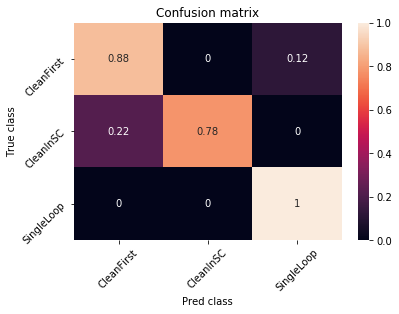

In [15]:
true = [dataset.dataset[i]['labels'].item() for i in range(len(trees))]
pred = [[dataset.dataset[j]['labels'].item() for j in sorted_idx] for sorted_idx in sorted_idxs]

def topk_pred(k):    
    return [mode(p[:k])[0][0] for t, p in zip(true, pred)]

class_names = [str(cls).split('.')[1] for cls in dataset.label_set]

evl = ClassEvaluation.from_preds(true, topk_pred(1), class_names)
print('Overall accuracy: {:.3f}'.format(evl.accuracy))
evl.plot_cm('Confusion matrix')

To investigate further, we show below every incorrectly labeled example with the actual program on the top, and the closest program by edit distance on the bottom. Some of these contain predictable syntactic similarity, e.g. two functions using List.fold_right in a structurally similar way, but still fundamentally having different strategies. This suggests that student solutions are consistent enough to reliably classify using NN methods, but the classifier still hasn't _really_ learned the essence of one solution type versus another.

In [19]:
idxs = evl.incorrect()
for i in idxs:
    print(dataset.dataset[i]['source'])
    print('='*30)
    print(dataset.dataset[sorted_idxs[i][0]]['source'])
    print('\n\n')
    print('='*80)


let rainfall (alon : int list) =
  (let rec rainfallHelp (alon : int list) (nlon : int list) =
     (match alon with
      | [] ->
          (List.fold_right (fun x -> fun y -> x + y) nlon 0) /
            (List.length nlon)
      | hd::tl ->
          (match hd with
           | (-999) ->
               if (List.length nlon) = 0
               then 0
               else
                 (List.fold_right (fun x -> fun y -> x + y) nlon 0) /
                   (List.length nlon)
           | _ ->
               if hd >= 0
               then rainfallHelp tl (hd :: nlon)
               else rainfallHelp tl nlon) : int) in
   rainfallHelp alon [] : int)

let rec rainfall (alon : int list) =
  (let rec avg_rain (alon : int list) (sum : int) (count : int) =
     (match alon with
      | [] -> if count = 0 then 0 else sum / count
      | hd::tl ->
          if hd > 0
          then avg_rain tl (sum + hd) (count + 1)
          else
            if hd > (-999)
            then avg_rain tl sum co

## Conclusion

Given the high quality of the nearest neighbors classifier, we need to understand if the neural network outperforms it on any metric. This would entail greater investigation into the NN classifier (how much labeled data does it need?) and the supervised classifier (does it do better if trained on all-but-1 of the data?). 